In [1]:
import numpy as np
import pandas as pd
import altair as alt
from vega_datasets import data

In [2]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
states = alt.topo_feature(data.us_10m.url, 'states')
election_data = pd.read_csv('data/nice_election_data_2008_to_2016.csv')
election_data.head()

fips_code          county  year      dem  dem_share      gop  gop_share  \
0       1001  Autauga County  2008   6093.0   0.257730  17403.0   0.736136   
1       1001  Autauga County  2012   6354.0   0.265758  17366.0   0.726337   
2       1001  Autauga County  2016   5908.0   0.239569  18110.0   0.734358   
3       1003  Baldwin County  2008  19386.0   0.238119  61271.0   0.752595   
4       1003  Baldwin County  2012  18329.0   0.215666  65772.0   0.773897   

     oth    total winner  dem_margin  
0  145.0  23641.0    gop   -0.478406  
1  189.0  23909.0    gop   -0.460580  
2  643.0  24661.0    gop   -0.494789  
3  756.0  81413.0    gop   -0.514476  
4  887.0  84988.0    gop   -0.558232

### Plot Democratic Share of Every County in the US
For some reason (Altair bug? JupyterLab bug?), this chart doesn't show up in the notebook.
However, if you follow the "Open in Vega Editor" link, it will render.

First, just 2016:

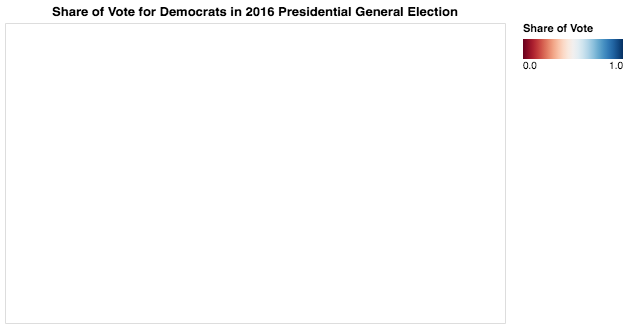

In [3]:
# Subset to just 2016
election_data_2016 = election_data[election_data['year'] == 2016]
alt.Chart(counties, title='Share of Vote for Democrats in 2016 Presidential General Election').mark_geoshape().encode(
    color=alt.Color('dem_share:Q',
                    scale=alt.Scale(domain=[0, 1],
                                    scheme='redblue'),
                    title='Share of Vote')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(election_data_2016,
                         'fips_code',
                         list(election_data_2016.columns))
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
)

Then, for each of the last three elections.

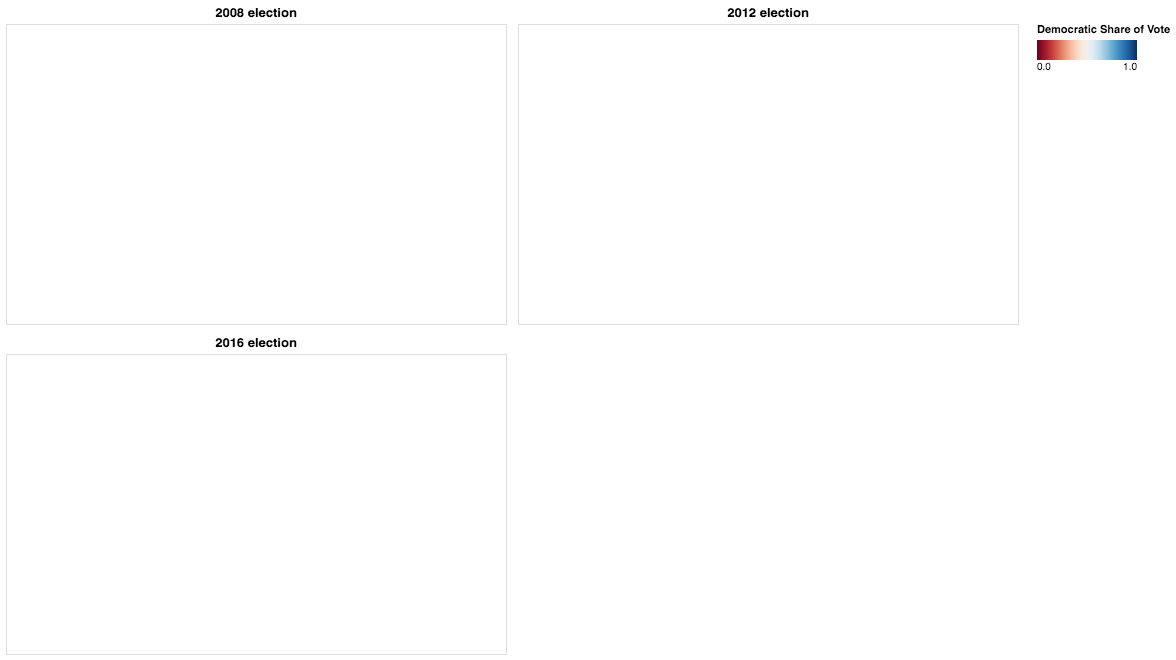

In [4]:
charts = []
for year, df in election_data.groupby('year'):
    chart = alt.Chart(counties, title='{} election'.format(year)).mark_geoshape().encode(
        color=alt.Color('dem_share:Q',
                        scale=alt.Scale(domain=[0, 1],
                                        scheme='redblue'),
                        title='Democratic Share of Vote')
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(df, 'fips_code', list(df.columns))
    ).properties(
        width=500,
        height=300
    ).project(
        type='albersUsa'
    )
    charts.append(chart)
(charts[0] & charts[2]) | charts[1]

### Plot Democratic Share of Every **State** in the US
This will take a little bit of aggregating first.

In [5]:
# Create the state FIPS -- the first two digits (or one digit, with zero-padding) of the county FIPS.
state_fips_codes = election_data['fips_code'].astype(str).str.slice(start=None, stop=-3) #.str.zfill(2)
election_data['state_fips_code'] = state_fips_codes
# Group by state FIPS and year, and keep only raw count columns.
state_data = election_data.groupby(['year', 'state_fips_code']).sum()[['dem', 'gop', 'oth', 'total']]
state_data.head()

dem        gop      oth      total
year state_fips_code                                          
2008 1                 813479.0  1266546.0  19794.0  2099819.0
     10                255459.0   152374.0   4579.0   412412.0
     11                245800.0    17367.0   2686.0   265853.0
     12               4282074.0  4045624.0  63046.0  8390744.0
     13               1844123.0  2048759.0  31590.0  3924472.0

In [6]:
# Recompute the dem_share column.
state_data['dem_share'] = state_data['dem'] / state_data['total']
state_data.head()

dem        gop      oth      total  dem_share
year state_fips_code                                                     
2008 1                 813479.0  1266546.0  19794.0  2099819.0   0.387404
     10                255459.0   152374.0   4579.0   412412.0   0.619427
     11                245800.0    17367.0   2686.0   265853.0   0.924571
     12               4282074.0  4045624.0  63046.0  8390744.0   0.510333
     13               1844123.0  2048759.0  31590.0  3924472.0   0.469903

In [7]:
# Copy the state_fips_code index back into a column. Hacky, but seemingly necessary to pass it to Altair as a join key.
state_data = state_data.reset_index()
state_data_2016 = state_data[state_data['year'] == 2016]
state_data_2016.head()

year state_fips_code        dem        gop       oth      total  \
100  2016               1   718084.0  1306925.0   53156.0  2078165.0   
101  2016              10   235581.0   185103.0   20851.0   441535.0   
102  2016              11   260223.0    11553.0    8496.0   280272.0   
103  2016              12  4485745.0  4605515.0  295490.0  9386750.0   
104  2016              13  1837300.0  2068623.0  123641.0  4029564.0   

     dem_share  
100   0.345538  
101   0.533550  
102   0.928466  
103   0.477881  
104   0.455955

Finally, chart it.

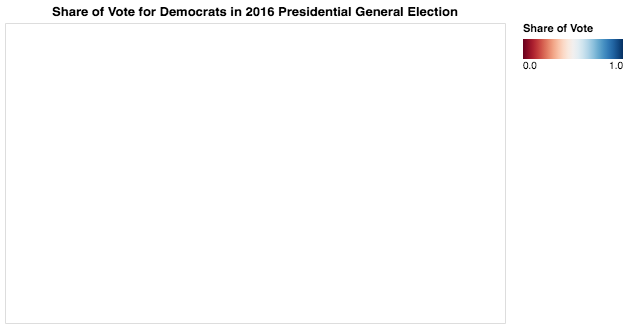

In [8]:
alt.Chart(states, title='Share of Vote for Democrats in 2016 Presidential General Election').mark_geoshape().encode(
    color=alt.Color('dem_share:Q',
                    scale=alt.Scale(domain=[0, 1],
                                    scheme='redblue'),
                    title='Share of Vote')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_data,
                         'state_fips_code',
                         list(state_data.columns))
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
)

### Now, let's get the crude "electoral college" visualization

In [9]:
electoral_data = state_data_2016.copy()
def get_dem_win(row):
    if row['dem'] > row['gop']:
        # Use .9 and .1 to get brighter colors, vs 1 and 0
        return .9
    else:
        return .1
electoral_data['dem_win'] = electoral_data.apply(get_dem_win, axis=1)
# Sorry Hawaii
electoral_data = electoral_data[electoral_data['state_fips_code'] != '15']
electoral_data.head()

year state_fips_code        dem        gop       oth      total  \
100  2016               1   718084.0  1306925.0   53156.0  2078165.0   
101  2016              10   235581.0   185103.0   20851.0   441535.0   
102  2016              11   260223.0    11553.0    8496.0   280272.0   
103  2016              12  4485745.0  4605515.0  295490.0  9386750.0   
104  2016              13  1837300.0  2068623.0  123641.0  4029564.0   

     dem_share  dem_win  
100   0.345538      0.1  
101   0.533550      0.9  
102   0.928466      0.9  
103   0.477881      0.1  
104   0.455955      0.1

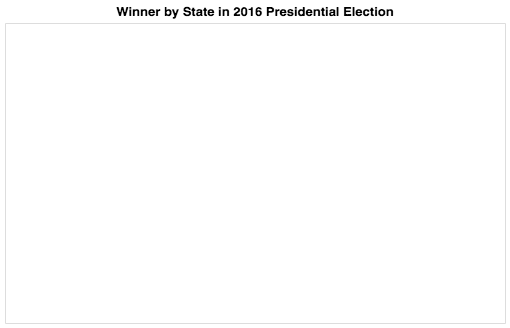

In [10]:
alt.Chart(states, title='Winner by State in 2016 Presidential Election').mark_geoshape().encode(
    color=alt.Color('dem_win:Q',
                    scale=alt.Scale(domain=[0,1],
                                    scheme='redblue'),
                    title='Winner by State',
                    legend=None)
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(electoral_data,
                         'state_fips_code',
                         list(electoral_data.columns))
).properties(
    width=500,
    height=300,
).project(
    type='albersUsa'
)